In [1]:
grouped_sensors = {
    'Frontal': ['FC3', 'FC2', 'F4', 'F1', 'F2', 'F5', 'F6', 'AF1', 'AF8', 'FC4', 'F8', 'AF2', 'AFZ', 'FZ', 'FPZ', 'FP2', 'F3', 'FT7', 'FP1', 'F7', 'FT8', 'FC6', 'FC1',  'FC5', 'AF7'],
    'Central': ['CZ', 'C3', 'C4', 'C5', 'C2', 'C1', 'FCZ', 'C6'],
    'Parietal': ['P1', 'P3', 'P8', 'P4', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'P2', 'PO2', 'PZ', 'CPZ', 'P5', 'PO1', 'P6',  'P7', 'PO8', 'PO7', 'POZ'],
    'Occipital': ['O2', 'OZ', 'O1'],
    'Temporal': ['TP7', 'T7', 'T8', 'TP8'],
    'Other': ['nd', 'Y', 'X',]
}

In [4]:
import random
import sys
from typing import Literal

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def read_file(file):
    df = pd.read_csv(file)
    df = df.rename(columns={"trial number": "trial_number",
                                "sample num": "sample_num",
                                "sensor value": "sensor_value",
                                "sensor position": "sensor_position",
                                "subject identifier": "subject_identifier",
                                "matching condition": "matching_condition"})
    #check data
    assert len(df.trial_number.unique()) == 1
    trial_number = int(df.trial_number.unique()[0])
    assert len(df.sample_num.unique()) == 256
    sensor_positions = df.sensor_position.unique()
    assert len(df.subject_identifier.unique()) == 1
    subject = df.subject_identifier.unique()[0]
    assert len(df.channel.unique()) == 64
    assert len(df.name.unique()) == 1
    name = df.name.unique()[0]
    matching_condition = list(df.matching_condition.unique())
    ts = df.pivot(index="sample_num", columns="sensor_position", values="sensor_value")
    subject_class = 1 if subject == "a" else 0
    return {
        "trial_number": trial_number,
        "sensor_positions": sensor_positions,
        "name": name,
        "time_series": ts,
        "matching_condition": matching_condition,
        "subject_identifier": subject,
        "class": subject_class,
        "frontal_time_series": ts[grouped_sensors['Frontal']],
        "central_time_series": ts[grouped_sensors['Central']],
        "parietal_time_series": ts[grouped_sensors['Parietal']],
        "occipital_time_series": ts[grouped_sensors['Occipital']],
        "temporal_time_series": ts[grouped_sensors['Temporal']],
        "other_time_series": ts[grouped_sensors['Other']]
    }

In [5]:
train_files = Path(r'./SMNI_CMI_TRAIN').glob('**/*')
test_files = Path(r'./SMNI_CMI_TEST').glob('**/*')
train_files = [x for x in train_files if x.is_file()]
test_files = [x for x in test_files if x.is_file()]
train_data = dict()
test_data = dict()

for f in train_files:
    train_data[f] = read_file(f)

for f in test_files:
    test_data[f] = read_file(f)

# Grouping sensors

In [58]:
first_key = next(iter(train_data.keys()))
list(set(train_data[first_key]['sensor_positions']))

['FC3',
 'P1',
 'AF2',
 'CP5',
 'CZ',
 'CPZ',
 'FZ',
 'AFZ',
 'CP2',
 'F4',
 'C3',
 'nd',
 'O2',
 'C1',
 'PO8',
 'P5',
 'P3',
 'FC1',
 'FPZ',
 'C4',
 'CP6',
 'PO1',
 'F1',
 'TP7',
 'F2',
 'O1',
 'CP1',
 'FP2',
 'F3',
 'AF8',
 'TP8',
 'PO7',
 'FCZ',
 'T7',
 'P8',
 'P4',
 'F5',
 'FT7',
 'CP3',
 'FP1',
 'FC5',
 'C6',
 'P6',
 'Y',
 'FC6',
 'F6',
 'C5',
 'AF1',
 'AF7',
 'CP4',
 'P2',
 'F7',
 'C2',
 'P7',
 'FC2',
 'X',
 'T8',
 'FC4',
 'PO2',
 'FT8',
 'F8',
 'OZ',
 'POZ',
 'PZ']

In [59]:
sensor_positions = set()
for key in train_data:
    #print(train_data[key]["sensor_positions"])
    sensor_positions = sensor_positions | set(train_data[key]["sensor_positions"])
for key in test_data:
    sensor_positions = sensor_positions | set(test_data[key]["sensor_positions"])

In [60]:
for el in list(sensor_positions):
    print(el, end=', ')

FC3, P1, CP5, CZ, AFZ, CP2, F4, C3, O2, P3, C4, CP6, F1, TP7, nd, F2, AF8, T7, P8, P4, F5, CP3, Y, FC6, F6, C5, AF1, P2, C2, T8, FC4, PO2, F8, OZ, PZ, AF2, CPZ, FZ, C1, PO8, P5, FC1, FPZ, PO1, FCZ, O1, CP1, FP2, F3, TP8, PO7, FT7, FP1, FC5, C6, P6, AF7, CP4, F7, P7, FC2, X, FT8, POZ, 

Frontal: FC3, F4, F1, F2, F5, F6, AF1, FC4, F8, AF2, FZ, FPZ, FP2, F3, FT7, FP1, F7, FT8

Central: CZ, C3, C4, C5, C2, C1, FCZ, C6

Parietal: P1, P3, P8, P4, CP3, P2, PO2, PZ, CPZ, P5, PO1, P6, CP4, P7

Occipital: O2, OZ, O1

Temporal: TP7, T7, T8, TP8

Other: CP5, AFZ, CP2, CP6, nd, AF8, Y, FC6, PO8, FC1, CP1, PO7, FC5, AF7, FC2, X, POZ


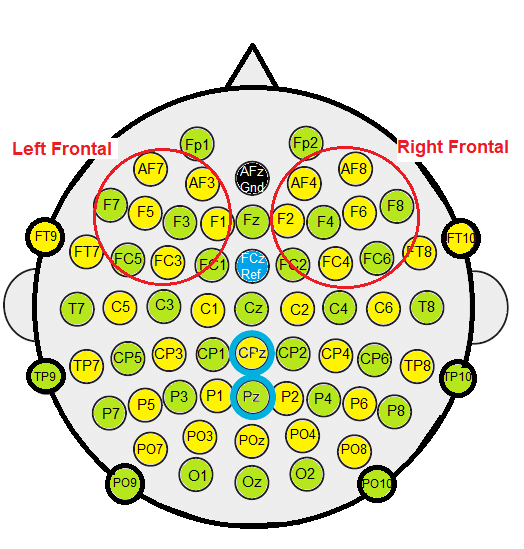

In [61]:
grouped_sensors = {
    'Frontal': ['FC3', 'FC2', 'F4', 'F1', 'F2', 'F5', 'F6', 'AF1', 'AF8', 'FC4', 'F8', 'AF2', 'AFZ', 'FZ', 'FPZ', 'FP2', 'F3', 'FT7', 'FP1', 'F7', 'FT8', 'FC6', 'FC1',  'FC5', 'AF7'],
    'Central': ['CZ', 'C3', 'C4', 'C5', 'C2', 'C1', 'FCZ', 'C6'],
    'Parietal': ['P1', 'P3', 'P8', 'P4', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'P2', 'PO2', 'PZ', 'CPZ', 'P5', 'PO1', 'P6',  'P7', 'PO8', 'PO7', 'POZ'],
    'Occipital': ['O2', 'OZ', 'O1'],
    'Temporal': ['TP7', 'T7', 'T8', 'TP8'],
    'Other': ['nd', 'Y', 'X',]
}

In [62]:
train_data[first_key]['time_series']

sensor_position,AF1,AF2,AF7,AF8,AFZ,C1,C2,C3,C4,C5,...,PO8,POZ,PZ,T7,T8,TP7,TP8,X,Y,nd
sample_num,,,,,,,,,,,,,,,,,,,,,
0,-2.146,1.129,-16.856,-10.020,-0.987,-1.129,2.747,-2.716,-0.926,-8.586,...,5.157,-6.266,-2.797,-6.805,-3.886,-9.338,-3.082,-5.269,-5.636,-8.901
1,-2.146,0.641,-7.090,-7.090,-1.475,-1.617,-1.160,-3.204,-2.879,-11.515,...,7.111,-8.708,-4.262,-9.247,-5.839,-12.268,-4.059,-5.758,-2.706,-7.924
2,-1.658,-0.336,7.558,1.211,-0.987,0.336,0.305,1.678,2.492,-11.027,...,-2.655,-9.196,-4.262,-8.270,-4.374,-8.850,-3.571,-2.828,1.689,-3.042
3,-0.682,-0.824,19.277,10.488,-0.010,0.824,0.305,-0.275,2.981,-6.632,...,-7.050,-6.755,-2.797,-3.876,0.020,-1.526,-1.129,1.567,5.595,4.771
4,2.248,0.641,23.183,13.906,2.431,2.777,2.258,4.608,5.910,1.180,...,-4.120,-3.337,-0.844,1.495,4.415,4.822,2.777,5.961,9.013,11.607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,1.272,5.035,1.211,-10.997,0.966,1.801,0.305,-1.251,-1.414,-0.285,...,3.693,-1.872,2.574,-6.805,4.903,-3.967,3.265,8.891,6.571,3.306
252,-0.682,4.059,5.117,-2.696,0.966,4.242,0.793,0.214,-2.879,0.692,...,3.693,-0.895,2.085,2.960,9.786,6.775,4.242,8.891,12.431,4.283
253,-0.193,2.106,8.046,9.511,0.478,9.613,-0.183,11.932,-5.320,2.645,...,-3.143,-0.895,1.597,11.261,10.763,14.587,2.777,11.820,15.849,4.771


In [63]:
frontal_time_series = train_data[first_key]['time_series'][grouped_sensors['Frontal']]

In [64]:
frontal_time_series.head()

sensor_position,FC3,FC2,F4,F1,F2,F5,F6,AF1,AF8,FC4,...,FP2,F3,FT7,FP1,F7,FT8,FC6,FC1,FC5,AF7
sample_num,,,,,,,,,,,,,,,,,,,,,
0,1.333,0.488,3.408,-0.407,0.529,-9.288,12.624,-2.146,-10.020,-6.846,...,0.834,-0.092,-10.162,-8.921,-19.847,-1.373,4.832,0.824,-2.431,-16.856
1,0.356,-0.977,1.455,0.081,-0.936,-13.194,6.765,-2.146,-7.090,-5.870,...,3.276,0.397,-10.162,-8.433,-12.522,-2.350,6.297,0.824,-4.384,-7.090
2,-1.597,-1.465,0.478,-0.407,-1.424,-12.705,-1.048,-1.658,1.211,0.966,...,5.717,-1.068,-0.397,-2.574,1.149,-5.280,5.809,0.336,-5.361,7.558
3,-3.062,0.000,0.966,-1.383,0.041,-7.823,-3.977,-0.682,10.488,6.826,...,7.670,-3.510,12.787,5.239,14.821,-3.815,3.367,-0.641,-5.361,19.277
4,-3.062,1.953,1.943,-1.383,2.482,-0.010,-0.071,2.248,13.906,6.337,...,9.623,-5.463,19.135,11.587,20.681,4.974,1.414,-1.129,-0.966,23.183


# Training on groups

## Only frontal

In [47]:
rows = len(train_data)
first_key = next(iter(train_data.keys()))
cols = train_data[first_key]["frontal_time_series"].shape[1]

train_stats = {stat: np.empty((rows, cols)) for stat in ["mean", "max", "min", "median", "std"]}

for i, (key, d) in enumerate(train_data.items()):
    ts = d["frontal_time_series"]
    train_stats["mean"][i], train_stats["max"][i], train_stats["min"][i], train_stats["median"][i], train_stats["std"][i] = ts.mean(axis=0), ts.max(axis=0), ts.min(axis=0), ts.median(axis=0), ts.std(axis=0)

In [48]:
train_classes = [1 if d["subject_identifier"] == "a" else 0 for d in train_data.values()]
test_classes = [1 if d["subject_identifier"] == "a" else 0 for d in test_data.values()]

In [49]:
rows = len(test_data)
first_key = next(iter(test_data.keys()))
cols = test_data[first_key]["frontal_time_series"].shape[1]

test_stats = {stat: np.empty((rows, cols)) for stat in ["mean", "max", "min", "median", "std"]}

for i, (key, d) in enumerate(test_data.items()):
    ts = d["frontal_time_series"]
    test_stats["mean"][i], test_stats["max"][i], test_stats["min"][i], test_stats["median"][i], test_stats["std"][i] = ts.mean(axis=0), ts.max(axis=0), ts.min(axis=0), ts.median(axis=0), ts.std(axis=0)

In [50]:
X_train = np.hstack((train_stats["min"], train_stats["mean"], train_stats["max"], train_stats["median"], train_stats["std"]))
y_train = np.array(train_classes)
X_test = np.hstack((test_stats["min"], test_stats["mean"], test_stats["max"], test_stats["median"], test_stats["std"]))
y_test = np.array(test_classes)

In [51]:
import lightgbm as lgb

train_data_lgb = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'multiclass',
    'num_class': 2,
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1
}

In [52]:
model = lgb.train(params,
                  train_data_lgb,
                  num_boost_round=1000,
                  valid_sets=[train_data_lgb],
                  valid_names=['train'],
                  )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31862
[LightGBM] [Info] Number of data points in the train set: 936, number of used features: 125
[LightGBM] [Info] Start training from score -0.697430
[LightGBM] [Info] Start training from score -0.688883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [53]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

Accuracy: 0.843750
F1 Score: 0.849095


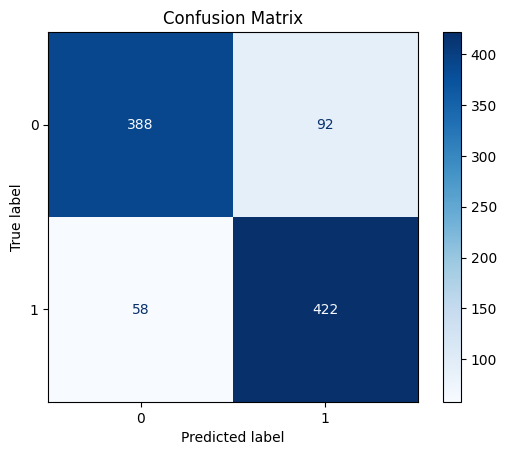

In [54]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

predicted = model.predict(X_test, num_iteration=model.best_iteration)

class_predictions = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, class_predictions)
print(f"Accuracy: {accuracy:.6f}")
f1 = f1_score(y_test, class_predictions)
print(f"F1 Score: {f1:.6f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, class_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## Only Central

In [6]:
rows = len(train_data)
first_key = next(iter(train_data.keys()))
cols = train_data[first_key]["central_time_series"].shape[1]

train_stats = {stat: np.empty((rows, cols)) for stat in ["mean", "max", "min", "median", "std"]}

for i, (key, d) in enumerate(train_data.items()):
    ts = d["central_time_series"]
    train_stats["mean"][i], train_stats["max"][i], train_stats["min"][i], train_stats["median"][i], train_stats["std"][i] = ts.mean(axis=0), ts.max(axis=0), ts.min(axis=0), ts.median(axis=0), ts.std(axis=0)

In [7]:
train_classes = [1 if d["subject_identifier"] == "a" else 0 for d in train_data.values()]
test_classes = [1 if d["subject_identifier"] == "a" else 0 for d in test_data.values()]

In [16]:
rows = len(test_data)
first_key = next(iter(test_data.keys()))
cols = test_data[first_key]["central_time_series"].shape[1]

test_stats = {stat: np.empty((rows, cols)) for stat in ["mean", "max", "min", "median", "std"]}

for i, (key, d) in enumerate(test_data.items()):
    ts = d["central_time_series"]
    test_stats["mean"][i], test_stats["max"][i], test_stats["min"][i], test_stats["median"][i], test_stats["std"][i] = ts.mean(axis=0), ts.max(axis=0), ts.min(axis=0), ts.median(axis=0), ts.std(axis=0)

In [18]:
X_train = np.hstack((train_stats["min"], train_stats["mean"], train_stats["max"], train_stats["median"], train_stats["std"]))
y_train = np.array(train_classes)
X_test = np.hstack((test_stats["min"], test_stats["mean"], test_stats["max"], test_stats["median"], test_stats["std"]))
y_test = np.array(test_classes)

In [19]:
import lightgbm as lgb

train_data_lgb = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'multiclass',
    'num_class': 2,
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1
}

In [13]:
model = lgb.train(params,
                  train_data_lgb,
                  num_boost_round=1000,
                  valid_sets=[train_data_lgb],
                  valid_names=['train'],
                  )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10198
[LightGBM] [Info] Number of data points in the train set: 936, number of used features: 40
[LightGBM] [Info] Start training from score -0.697430
[LightGBM] [Info] Start training from score -0.688883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [20]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

Accuracy: 0.847917
F1 Score: 0.838852


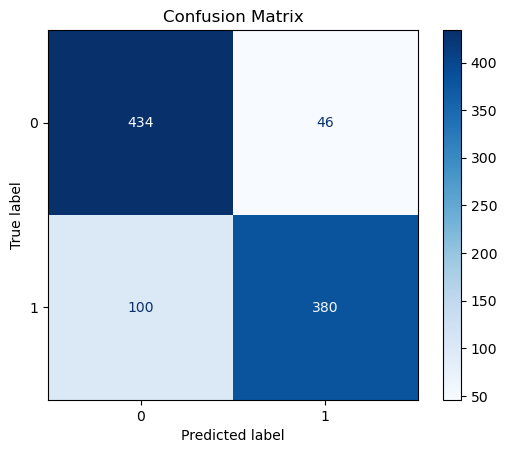

In [21]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

predicted = model.predict(X_test, num_iteration=model.best_iteration)

class_predictions = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, class_predictions)
print(f"Accuracy: {accuracy:.6f}")
f1 = f1_score(y_test, class_predictions)
print(f"F1 Score: {f1:.6f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, class_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## Only Parietal

In [22]:
rows = len(train_data)
first_key = next(iter(train_data.keys()))
cols = train_data[first_key]["parietal_time_series"].shape[1]

train_stats = {stat: np.empty((rows, cols)) for stat in ["mean", "max", "min", "median", "std"]}

for i, (key, d) in enumerate(train_data.items()):
    ts = d["parietal_time_series"]
    train_stats["mean"][i], train_stats["max"][i], train_stats["min"][i], train_stats["median"][i], train_stats["std"][i] = ts.mean(axis=0), ts.max(axis=0), ts.min(axis=0), ts.median(axis=0), ts.std(axis=0)

In [23]:
train_classes = [1 if d["subject_identifier"] == "a" else 0 for d in train_data.values()]
test_classes = [1 if d["subject_identifier"] == "a" else 0 for d in test_data.values()]

In [24]:
rows = len(test_data)
first_key = next(iter(test_data.keys()))
cols = test_data[first_key]["parietal_time_series"].shape[1]

test_stats = {stat: np.empty((rows, cols)) for stat in ["mean", "max", "min", "median", "std"]}

for i, (key, d) in enumerate(test_data.items()):
    ts = d["parietal_time_series"]
    test_stats["mean"][i], test_stats["max"][i], test_stats["min"][i], test_stats["median"][i], test_stats["std"][i] = ts.mean(axis=0), ts.max(axis=0), ts.min(axis=0), ts.median(axis=0), ts.std(axis=0)

In [25]:
X_train = np.hstack((train_stats["min"], train_stats["mean"], train_stats["max"], train_stats["median"], train_stats["std"]))
y_train = np.array(train_classes)
X_test = np.hstack((test_stats["min"], test_stats["mean"], test_stats["max"], test_stats["median"], test_stats["std"]))
y_test = np.array(test_classes)

In [26]:
import lightgbm as lgb

train_data_lgb = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'multiclass',
    'num_class': 2,
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1
}

In [28]:
model = lgb.train(params,
                  train_data_lgb,
                  num_boost_round=1000,
                  valid_sets=[train_data_lgb],
                  valid_names=['train'],
                  )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26773
[LightGBM] [Info] Number of data points in the train set: 936, number of used features: 105
[LightGBM] [Info] Start training from score -0.697430
[LightGBM] [Info] Start training from score -0.688883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [29]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

Accuracy: 0.841667
F1 Score: 0.837607


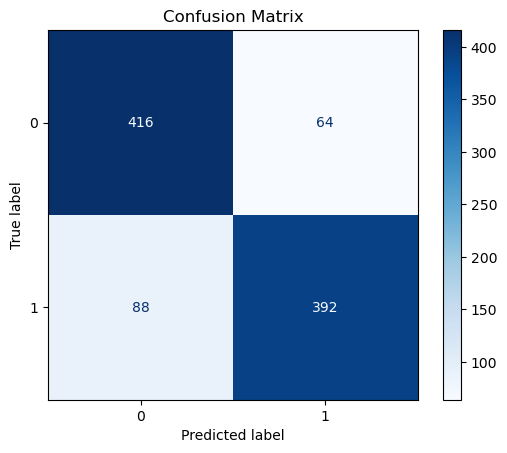

In [30]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

predicted = model.predict(X_test, num_iteration=model.best_iteration)

class_predictions = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, class_predictions)
print(f"Accuracy: {accuracy:.6f}")
f1 = f1_score(y_test, class_predictions)
print(f"F1 Score: {f1:.6f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, class_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## Only Occipital

In [31]:
rows = len(train_data)
first_key = next(iter(train_data.keys()))
cols = train_data[first_key]["occipital_time_series"].shape[1]

train_stats = {stat: np.empty((rows, cols)) for stat in ["mean", "max", "min", "median", "std"]}

for i, (key, d) in enumerate(train_data.items()):
    ts = d["occipital_time_series"]
    train_stats["mean"][i], train_stats["max"][i], train_stats["min"][i], train_stats["median"][i], train_stats["std"][i] = ts.mean(axis=0), ts.max(axis=0), ts.min(axis=0), ts.median(axis=0), ts.std(axis=0)

In [32]:
train_classes = [1 if d["subject_identifier"] == "a" else 0 for d in train_data.values()]
test_classes = [1 if d["subject_identifier"] == "a" else 0 for d in test_data.values()]

In [33]:
rows = len(test_data)
first_key = next(iter(test_data.keys()))
cols = test_data[first_key]["occipital_time_series"].shape[1]

test_stats = {stat: np.empty((rows, cols)) for stat in ["mean", "max", "min", "median", "std"]}

for i, (key, d) in enumerate(test_data.items()):
    ts = d["occipital_time_series"]
    test_stats["mean"][i], test_stats["max"][i], test_stats["min"][i], test_stats["median"][i], test_stats["std"][i] = ts.mean(axis=0), ts.max(axis=0), ts.min(axis=0), ts.median(axis=0), ts.std(axis=0)

In [34]:
X_train = np.hstack((train_stats["min"], train_stats["mean"], train_stats["max"], train_stats["median"], train_stats["std"]))
y_train = np.array(train_classes)
X_test = np.hstack((test_stats["min"], test_stats["mean"], test_stats["max"], test_stats["median"], test_stats["std"]))
y_test = np.array(test_classes)

In [35]:
import lightgbm as lgb

train_data_lgb = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'multiclass',
    'num_class': 2,
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1
}

In [36]:
model = lgb.train(params,
                  train_data_lgb,
                  num_boost_round=1000,
                  valid_sets=[train_data_lgb],
                  valid_names=['train'],
                  )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 936, number of used features: 15
[LightGBM] [Info] Start training from score -0.697430
[LightGBM] [Info] Start training from score -0.688883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

In [37]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

Accuracy: 0.689583
F1 Score: 0.680942


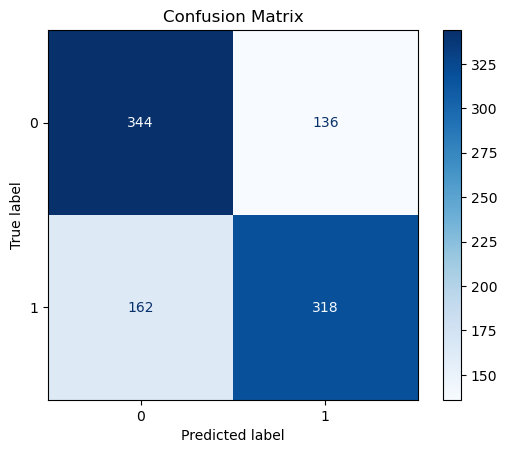

In [38]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

predicted = model.predict(X_test, num_iteration=model.best_iteration)

class_predictions = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, class_predictions)
print(f"Accuracy: {accuracy:.6f}")
f1 = f1_score(y_test, class_predictions)
print(f"F1 Score: {f1:.6f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, class_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## Only Temporal

In [39]:
rows = len(train_data)
first_key = next(iter(train_data.keys()))
cols = train_data[first_key]["temporal_time_series"].shape[1]

train_stats = {stat: np.empty((rows, cols)) for stat in ["mean", "max", "min", "median", "std"]}

for i, (key, d) in enumerate(train_data.items()):
    ts = d["temporal_time_series"]
    train_stats["mean"][i], train_stats["max"][i], train_stats["min"][i], train_stats["median"][i], train_stats["std"][i] = ts.mean(axis=0), ts.max(axis=0), ts.min(axis=0), ts.median(axis=0), ts.std(axis=0)

In [40]:
train_classes = [1 if d["subject_identifier"] == "a" else 0 for d in train_data.values()]
test_classes = [1 if d["subject_identifier"] == "a" else 0 for d in test_data.values()]

In [41]:
rows = len(test_data)
first_key = next(iter(test_data.keys()))
cols = test_data[first_key]["temporal_time_series"].shape[1]

test_stats = {stat: np.empty((rows, cols)) for stat in ["mean", "max", "min", "median", "std"]}

for i, (key, d) in enumerate(test_data.items()):
    ts = d["temporal_time_series"]
    test_stats["mean"][i], test_stats["max"][i], test_stats["min"][i], test_stats["median"][i], test_stats["std"][i] = ts.mean(axis=0), ts.max(axis=0), ts.min(axis=0), ts.median(axis=0), ts.std(axis=0)

In [42]:
X_train = np.hstack((train_stats["min"], train_stats["mean"], train_stats["max"], train_stats["median"], train_stats["std"]))
y_train = np.array(train_classes)
X_test = np.hstack((test_stats["min"], test_stats["mean"], test_stats["max"], test_stats["median"], test_stats["std"]))
y_test = np.array(test_classes)

In [43]:
import lightgbm as lgb

train_data_lgb = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'multiclass',
    'num_class': 2,
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1
}

In [44]:
model = lgb.train(params,
                  train_data_lgb,
                  num_boost_round=1000,
                  valid_sets=[train_data_lgb],
                  valid_names=['train'],
                  )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 936, number of used features: 20
[LightGBM] [Info] Start training from score -0.697430
[LightGBM] [Info] Start training from score -0.688883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

In [45]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

Accuracy: 0.664583
F1 Score: 0.658174


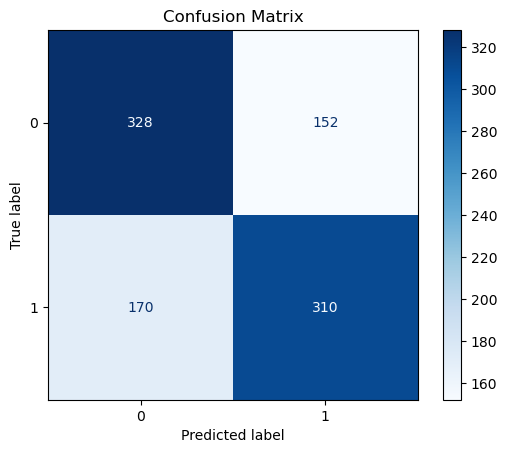

In [46]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

predicted = model.predict(X_test, num_iteration=model.best_iteration)

class_predictions = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, class_predictions)
print(f"Accuracy: {accuracy:.6f}")
f1 = f1_score(y_test, class_predictions)
print(f"F1 Score: {f1:.6f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, class_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Only Other


In [47]:
rows = len(train_data)
first_key = next(iter(train_data.keys()))
cols = train_data[first_key]["other_time_series"].shape[1]

train_stats = {stat: np.empty((rows, cols)) for stat in ["mean", "max", "min", "median", "std"]}

for i, (key, d) in enumerate(train_data.items()):
    ts = d["other_time_series"]
    train_stats["mean"][i], train_stats["max"][i], train_stats["min"][i], train_stats["median"][i], train_stats["std"][i] = ts.mean(axis=0), ts.max(axis=0), ts.min(axis=0), ts.median(axis=0), ts.std(axis=0)

In [48]:
train_classes = [1 if d["subject_identifier"] == "a" else 0 for d in train_data.values()]
test_classes = [1 if d["subject_identifier"] == "a" else 0 for d in test_data.values()]

In [49]:
rows = len(test_data)
first_key = next(iter(test_data.keys()))
cols = test_data[first_key]["other_time_series"].shape[1]

test_stats = {stat: np.empty((rows, cols)) for stat in ["mean", "max", "min", "median", "std"]}

for i, (key, d) in enumerate(test_data.items()):
    ts = d["other_time_series"]
    test_stats["mean"][i], test_stats["max"][i], test_stats["min"][i], test_stats["median"][i], test_stats["std"][i] = ts.mean(axis=0), ts.max(axis=0), ts.min(axis=0), ts.median(axis=0), ts.std(axis=0)

In [50]:
X_train = np.hstack((train_stats["min"], train_stats["mean"], train_stats["max"], train_stats["median"], train_stats["std"]))
y_train = np.array(train_classes)
X_test = np.hstack((test_stats["min"], test_stats["mean"], test_stats["max"], test_stats["median"], test_stats["std"]))
y_test = np.array(test_classes)

In [51]:
import lightgbm as lgb

train_data_lgb = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'multiclass',
    'num_class': 2,
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1
}

In [52]:
model = lgb.train(params,
                  train_data_lgb,
                  num_boost_round=1000,
                  valid_sets=[train_data_lgb],
                  valid_names=['train'],
                  )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 936, number of used features: 15
[LightGBM] [Info] Start training from score -0.697430
[LightGBM] [Info] Start training from score -0.688883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

In [53]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

Accuracy: 0.700000
F1 Score: 0.700000


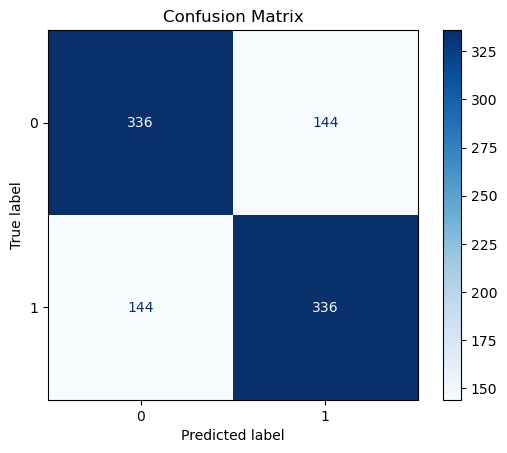

In [54]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

predicted = model.predict(X_test, num_iteration=model.best_iteration)

class_predictions = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, class_predictions)
print(f"Accuracy: {accuracy:.6f}")
f1 = f1_score(y_test, class_predictions)
print(f"F1 Score: {f1:.6f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, class_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()